In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [6]:
email_path = "PDA/buisness_emails/202501  CP-10011-2025-001  MINERVA PSARA  DISCHARGE VOYAGE INSTRUCTIONS.msg"

In [7]:
from typing import Annotated, List, Dict, Any

class Attachment(TypedDict):
    name: str
    path: str
    content: str
    
class State(TypedDict):
    email_file_path :str
    email_content: str
    email_subject :str
    attachments: List[Attachment]
    current_attachment_index: int = 0  # setting state with 0 
    customer_details: List[Dict[str, Any]]
    vessel_details: List[Dict[str, Any]]
    port_details: List[Dict[str, Any]]
    service_details: List[Dict[str, Any]]
    customer_summary: str
    vessel_summary: str
    port_summary: str
    service_summary: str
    final_summary: str
    messages: Annotated[list, add_messages]

In [8]:
from langchain_openai import AzureChatOpenAI
from langchain_core.tools import tool
import os

model_name = "gpt-4o"
deployment = "azure-gpt-4o"

api_version = "2024-12-01-preview"
endpoint = os.getenv("AZURE_OPENAI_URL")
subscription_key = os.getenv("AZURE_OPENAI_KEY")
llm = AzureChatOpenAI(
    azure_deployment=deployment,
    azure_endpoint=endpoint,
    api_version=api_version,  
    temperature=0.7,
    api_key=subscription_key
)


In [9]:
#test of read_file
import importlib
import file_reader
importlib.reload(file_reader)
from file_reader import read_file, read_msg
content = read_msg('buisness_emails/202501  CP-10011-2025-001  MINERVA PSARA  DISCHARGE VOYAGE INSTRUCTIONS.msg')

msg <extract_msg.msg_classes.message.Message object at 0x7365640dab10>


In [10]:
# @tool
# def read_file(file_path: str):
#     """Read the file. Userful for related information for shipping agent to make quotation details and estimate for customer"""
#     results = read_file(file_path)
#     return results

# tools = [read_file]
# llm_with_tools = llm.bind_tools(tools=tools)

In [11]:
def extract_customer_details(state: State) -> State:
    """Extract customer details from the current attachment"""
    if state["current_attachment_index"] >= len(state["attachments"]):
        return state
    
    current_attachment = state["attachments"][state["current_attachment_index"]]
    
    prompt = f"""
    You are shipping agent specialized in extracting customer details.
    
    Email subject: {state['email_subject']}
    Email content: {state['email_content']}
    
    Attachment name: {current_attachment['name']}
    
    Content of the attachment:
    {current_attachment.get('content', 'No content available')}
    
    Extract all customer details such as:
    - Customer name
    - Contact information
    - Company details
    - Any customer-specific requirements
    
    Format your response as a structured JSON.
    """
    
    response = llm.invoke(prompt)
    
    # Add to customer details list
    customer_details = state["customer_details"].copy()
    customer_details.append({
        "attachment_name": current_attachment["name"],
        "details": response.content
    })
    
    return {
        "customer_details": customer_details
    }

def extract_vessel_details(state: State) -> State:
    """Extract vessel details from the current attachment"""
    if state["current_attachment_index"] >= len(state["attachments"]):
        return state
    
    current_attachment = state["attachments"][state["current_attachment_index"]]
    
    prompt = f"""
    You are shipping agent, specialized in extracting vessel details.
    
    Email subject: {state['email_subject']}
    Email content: {state['email_content']}
    
    Attachment name: {current_attachment['name']}
    
    Content of the attachment:
    {current_attachment.get('content', 'No content available')}
    
    Extract all vessel details such as:
    - Vessel name
    - Vessel type
    - IMO number
    - Dimensions
    - Capacity
    - Any vessel-specific information
    
    Format your response as a structured JSON.
    """
    
    response = llm.invoke(prompt)
    
    # Add to vessel details list
    vessel_details = state["vessel_details"].copy()
    vessel_details.append({
        "attachment_name": current_attachment["name"],
        "details": response.content
    })
    
    return {
        "vessel_details": vessel_details
    }

def extract_port_details(state: State) -> State:
    """Extract port details from the current attachment"""
    if state["current_attachment_index"] >= len(state["attachments"]):
        return state
    
    current_attachment = state["attachments"][state["current_attachment_index"]]
    
    prompt = f"""
    You are shipping agent  specialized in extracting port details.
    
    Email content: {state['email_content']}
    Email content: {state['email_subject']}
    Attachment name: {current_attachment['name']}
    
    Content of the attachment:
    {current_attachment.get('content', 'No content available')}
    
    Extract all port details such as:
    - Port names
    - Locations
    - Loading/discharge information
    - Port restrictions
    - ETA/ETD
    - Any port-specific requirements
    
    Format your response as a structured JSON.
    """
    
    response = llm.invoke(prompt)
    
    # Add to port details list
    port_details = state["port_details"].copy()
    port_details.append({
        "attachment_name": current_attachment["name"],
        "details": response.content
    })
    
    return {
        "port_details": port_details
    }

def extract_service_details(state: State) -> State:
    """Extract service details from the current attachment"""
    if state["current_attachment_index"] >= len(state["attachments"]):
        return state
    
    current_attachment = state["attachments"][state["current_attachment_index"]]
    
    prompt = f"""
    You are shipping agent  specialized in extracting service details of ports.
    
    Email subject: {state['email_subject']}
    Email content: {state['email_content']}

    Attachment name: {current_attachment['name']}
    
    Content of the attachment:
    {current_attachment.get('content', 'No content available')}
    
    Extract all service details such as:
    - Required shipping services
    - Special handling requirements
    - Insurance needs
    - Documentation requirements
    - Timeline expectations
    - Any other service-related information
    
    Format your response as a structured JSON.
    """
    
    response = llm.invoke(prompt)
    
    # Add to service details list
    service_details = state["service_details"].copy()
    service_details.append({
        "attachment_name": current_attachment["name"],
        "details": response.content
    })
    print(service_details,service_details)
    return {
        "service_details": service_details
    }

def increment_attachment_index(state: State) -> State:
    """Move to the next attachment"""
    print(state["current_attachment_index"])
    return {
        "current_attachment_index": state["current_attachment_index"] + 1
    }

In [12]:
def should_process_more_attachments(state: State) -> str:
    if state["current_attachment_index"] < len(state["attachments"]):
        return "CONTINUE"
    else:
        return "FINAL_SUMMARIZE"

In [13]:
def summarize_customer_details(state: State) -> State:
    """Summarize all customer details from all attachments"""
    print("inside summarize_customer_details")
    if not state["customer_details"]:
        return { "customer_summary": "No customer details found."}
    
    prompt = f"""
    You are shipping agent, specialized in summarizing customer details.
    
    Email subject: {state['email_subject']}
    Email content: {state['email_content']}
    
    Here are the customer details extracted from all attachments:
    
    {state['customer_details']}
    
    Please provide a comprehensive summary of all customer details, resolving any conflicts
    and highlighting the most important information. Format your response in a clear, structured manner.
    """
    
    response = llm.invoke(prompt)
    
    return {
        "customer_summary": response.content
    }

def summarize_vessel_details(state: State) -> State:
    """Summarize all vessel details from all attachments"""
    print("inside summarize_vessel_details")
    if not state["vessel_details"]:
        return {"vessel_summary": "No vessel details found."}
    
    prompt = f"""
    You are shipping agent , specialized in summarizing vessel details.
    
    Email subject: {state['email_subject']}
    Email content: {state['email_content']}
    
    Here are the vessel details extracted from all attachments:
    
    {state['vessel_details']}
    
    Extract all vessel details such as:
    - Vessel name
    - Vessel type
    - IMO number
    - Dimensions
    - Capacity
    - Any vessel-specific information

    Please provide a comprehensive summary of all vessel details, resolving any conflicts
    and highlighting the most important information. Format your response in a clear, structured manner.
    """
    
    response = llm.invoke(prompt)
    print("end of  summarize_vessel_details")
    return {
        "vessel_summary": response.content
    }

def summarize_port_details(state: State) -> State:
    """Summarize all port details from all attachments"""
    print("inside summarize_port_details")
    if not state["port_details"]:
        return {"port_summary": "No port details found."}
    
    prompt = f"""
    You are shipping agent, specialized in summarizing port details.
    
    Email subject: {state['email_subject']}
    Email content: {state['email_content']}
    
    Here are the port details extracted from all attachments:
    
    {state['port_details']}
    
    Please provide a comprehensive summary of all port details, resolving any conflicts
    and highlighting the most important information. Format your response in a clear, structured manner.
    """
    
    response = llm.invoke(prompt)
    print("end of  summarize_port_details")
    return {
        "port_summary": response.content
    }

def summarize_service_details(state: State) -> State:
    """Summarize all service details from all attachments"""
    print("inside summarize_service_details")
    if not state["service_details"]:
        return { "service_summary": "No service details found."}
    
    prompt = f"""
    You are shipping agent, specialized in summarizing service details.
    
    Email subject: {state['email_subject']}
    Email content: {state['email_content']}
    
    Here are the service details extracted from all attachments:
    
    {state['service_details']}
    
    Please provide a comprehensive summary of all service details, resolving any conflicts
    and highlighting the most important information. Format your response in a clear, structured manner.
    """
    
    response = llm.invoke(prompt)
    print("end of  summarize_service_details")
    return {
        "service_summary": response.content
    }

def create_final_summary(state: State) -> State:
    """Create a final structured summary from all category summaries"""
    schema = '''{
        "to": {
            "company": "Name of the recipient company/client",
            "org_no": "Organization/registration number of the recipient",
            "address": "Physical address of the recipient",
            "country": "Country where the recipient is located",
            "phone": "Phone number of the recipient",
            "proforma_number": "Invoice/proforma number",
            "date": "Date of the proforma/invoice",
            "job_ref": "Job reference number",
            "contact_person": "Name of the contact person at the recipient company"
        },
        "from": {
            "company": "Name of the sender company/agent",
            "address": "Physical address of the sender",
            "phone": "Phone number of the sender",
            "fax": "Fax number of the sender",
            "web": "Website of the sender"
        },
        "proforma": {
            "vessel": "Name of the vessel/ship",
            "IMO": "IMO number of the vessel (7-digit unique ship identifier)",
            "gt": "Gross tonnage of the vessel (number only)",
            "nt": "Net tonnage of the vessel (number only)",
            "voyage": "Voyage name/destination",
            "eta": "Estimated time of arrival",
            "etd": "Estimated time of departure",
            "port_country": "Port and country of call",
            "call_type": "Type of port call (e.g., Cargo, Bunker)",
            "items": [
                {
                    "description": "Description of the service/fee",
                    "note": "Additional notes about the service",
                    "proforma_gbp": "Pro forma amount in GBP (number only)",
                    "final_gbp": "Final amount in GBP (number only)",
                    "variance": "Variance between pro forma and final amounts"
                }
            ],
            "total_gbp": "Total amount in GBP (number only)",
            "estimated_amount": "Estimated amount as a formatted string (e.g., 'GBP 391.00')"
        }
    }'''
    prompt = f"""
    You are shipping agent at port, specialized in creating comprehensive structured summaries.
    
    Email subject:{state['email_subject']}
    Email content: {state['email_content']}
    
    Here are the summaries from each specialized agent:
    
    CUSTOMER DETAILS:
    {state['customer_summary']}
    
    VESSEL DETAILS:
    {state['vessel_summary']}
    
    PORT DETAILS:
    {state['port_summary']}
    
    SERVICE DETAILS:
    {state['service_summary']}
    
    Schema:
    {schema}

    Definitions and synonyms:
    - company: Could be referred to as recipient, client, customer, addressee, consignee
    - org_no: Could be referred to as organization number, registration number, reg no, company number, VAT number
    - proforma_number: Could be referred to as pro forma no, invoice number, reference number, ref no, invoice no
    - vessel: Could be referred to as ship, M/V, MV, boat, tanker, carrier
    - IMO: Could be referred to as IMO number, ship number, vessel ID, international maritime organization number
    - gt: Could be referred to as gross tonnage, gross tons, GRT
    - nt: Could be referred to as net tonnage, net tons, NRT
    - eta: Could be referred to as estimated time of arrival, arrival, arriving, expected arrival, arrival date
    - etd: Could be referred to as estimated time of departure, departure, departing, expected departure, sailing date
    - items: Services, charges, fees, tariffs, line items
    - proforma_gbp: Pro forma amount in British Pounds Sterling (£)
    - call_type: Purpose of call, visit type, call purpose

    Pay special attention to IMO numbers, which are 7-digit unique identifiers for vessels. They often appear as "IMO:" followed by the number or in vessel details sections.

    Output ONLY valid JSON matching the schema above. Don't include any explanations or text before or after the JSON.  
    """
    #   
    #GIve a sumary of the entire email required to make a Proforma report for customer
    response = llm.invoke(prompt)
    
    return {
       # **state,
        "final_summary": response.content,
        "messages": [
            {"role": "user", "content": "Please provide a summary of the email and attachments."},
            {"role": "assistant", "content": response.content}
        ]
    }

In [14]:
def join(state_dict: Dict[str, State]) -> State:
    """
    Join the results from all parallel extraction tasks.
    This is a special type of node that takes a dictionary of states from multiple branches.
    """
    # Get the states from each extraction branch
    customer_state = state_dict.get("extract_customer_details", {})
    vessel_state = state_dict.get("extract_vessel_details", {})
    port_state = state_dict.get("extract_port_details", {})
    service_state = state_dict.get("extract_service_details", {})
    
    # Combine the results
    return {
        #**state_dict.get("process_attachment", {}),  # Base state
        "customer_details": customer_state.get("customer_details", []),
        "vessel_details": vessel_state.get("vessel_details", []),
        "port_details": port_state.get("port_details", []),
        "service_details": service_state.get("service_details", [])
    }

In [15]:
email_path='buisness_emails/202501  CP-10011-2025-001  MINERVA PSARA  DISCHARGE VOYAGE INSTRUCTIONS.msg'

In [16]:
c=read_msg(email_path)

msg <extract_msg.msg_classes.message.Message object at 0x73655e4d4fb0>


In [17]:
len(c["attachments"])

2

In [18]:
def process_email(state: State) -> State:
    """Process the current attachment and add its content to the state"""    
    updated_state = {}
    
    email_file_path = state["email_file_path"]
    if email_file_path:
        try:
            email_data = read_msg(email_file_path)
            updated_state = {
                 **state,
                "email_content": email_data["body"],
                "email_subject":email_data["subject"],
                "attachments": [
                    {
                        "name": attachment["filename"],
                        #"type": "email_attachment",
                        "path": attachment["temp_path"],
                        "content": "",
                    } 
                    for attachment in email_data["attachments"]
                ]
            }
            
        except Exception as e:
            print(f"Error reading email: {str(e)}")
       
    print("inside email process")
    print(updated_state)
    return updated_state

In [19]:
def process_attachment(state: State) -> State:
    """Process the current attachment and add its content to the state"""    
    print("start of process_attachments")
    if state["current_attachment_index"] >= len(state["attachments"]):
        return state
    
    current_attachment = state["attachments"][state["current_attachment_index"]]
    file_path = current_attachment["path"]
    file_content = read_file(file_path)
    
    updated_attachments = state["attachments"].copy()
    updated_attachments[state["current_attachment_index"]]["content"] = file_content
    
    print("end of process_attachments")
    return {
        **state,  # Maintain all existing state
        "attachments": updated_attachments
    }

In [20]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
initial_state = {
    "email_file_path": email_path,
    "email_content": "",  
    "attachments": [],  
    "current_attachment_index": 0,
    "customer_details": [],
    "vessel_details": [],
    "port_details": [],
    "service_details": [],
    "customer_summary": "",
    "vessel_summary":  "",
    "port_summary":  "",
    "service_summary":  "",
    "final_summary":  ""
}
# Augmented LLM with Tools Node function
# def tool_calling_llm(state: State) -> State:
#     current_state = state["messages"]
#     return {"messages": [llm_with_tools.invoke(current_state)]}


builder = StateGraph(State)
    
builder.add_node("process_email", process_email)
builder.add_node("process_attachment", process_attachment)

builder.add_node("extract_customer_details", extract_customer_details)
builder.add_node("extract_vessel_details", extract_vessel_details)
builder.add_node("extract_port_details", extract_port_details)
builder.add_node("extract_service_details", extract_service_details)
builder.add_node("increment_attachment_index", increment_attachment_index)

builder.add_node("summarize_customer_details", summarize_customer_details)
builder.add_node("summarize_vessel_details", summarize_vessel_details)
builder.add_node("summarize_port_details", summarize_port_details)
builder.add_node("summarize_service_details", summarize_service_details)
builder.add_node("create_final_summary", create_final_summary)
builder.add_node("join_summaries", join)


builder.add_edge(START, "process_email")
builder.add_edge("process_email", "process_attachment")
builder.add_edge("process_attachment", "extract_customer_details") 
builder.add_edge("process_attachment", "extract_vessel_details") 
builder.add_edge("process_attachment", "extract_port_details") 
builder.add_edge("process_attachment", "extract_service_details")

builder.add_node("join", join)
builder.add_edge("extract_customer_details", "join")
builder.add_edge("extract_vessel_details", "join")
builder.add_edge("extract_port_details", "join")
builder.add_edge("extract_service_details", "join")
builder.add_edge("join", "increment_attachment_index")
builder.add_conditional_edges(
        "increment_attachment_index",
        should_process_more_attachments,
        {
            "CONTINUE": "process_attachment",
            "FINAL_SUMMARIZE": "summarize_branch"
        }
    )
# Add a branch node for parallel summarization
builder.add_node("summarize_branch", lambda x: x)

# Connect branch node to all summarization nodes in parallel
builder.add_edge("summarize_branch", "summarize_customer_details")
builder.add_edge("summarize_branch", "summarize_vessel_details")
builder.add_edge("summarize_branch", "summarize_port_details")
builder.add_edge("summarize_branch", "summarize_service_details")

# Join all summarization results
builder.add_edge("summarize_customer_details", "join_summaries")
builder.add_edge("summarize_vessel_details", "join_summaries")
builder.add_edge("summarize_port_details", "join_summaries")
builder.add_edge("summarize_service_details", "join_summaries")

# Create final summary and end
builder.add_edge("join_summaries", "create_final_summary")
builder.add_edge("create_final_summary", END)
# Conditional Edge
# builder.add_conditional_edges(
#     "tool_calling_llm",
#     tools_condition,
#     ["tools", END]
# )
# builder.add_edge("tools", "tool_calling_llm") # this is the key feedback loop
# builder.add_edge("tools", END)
agent = builder.compile()

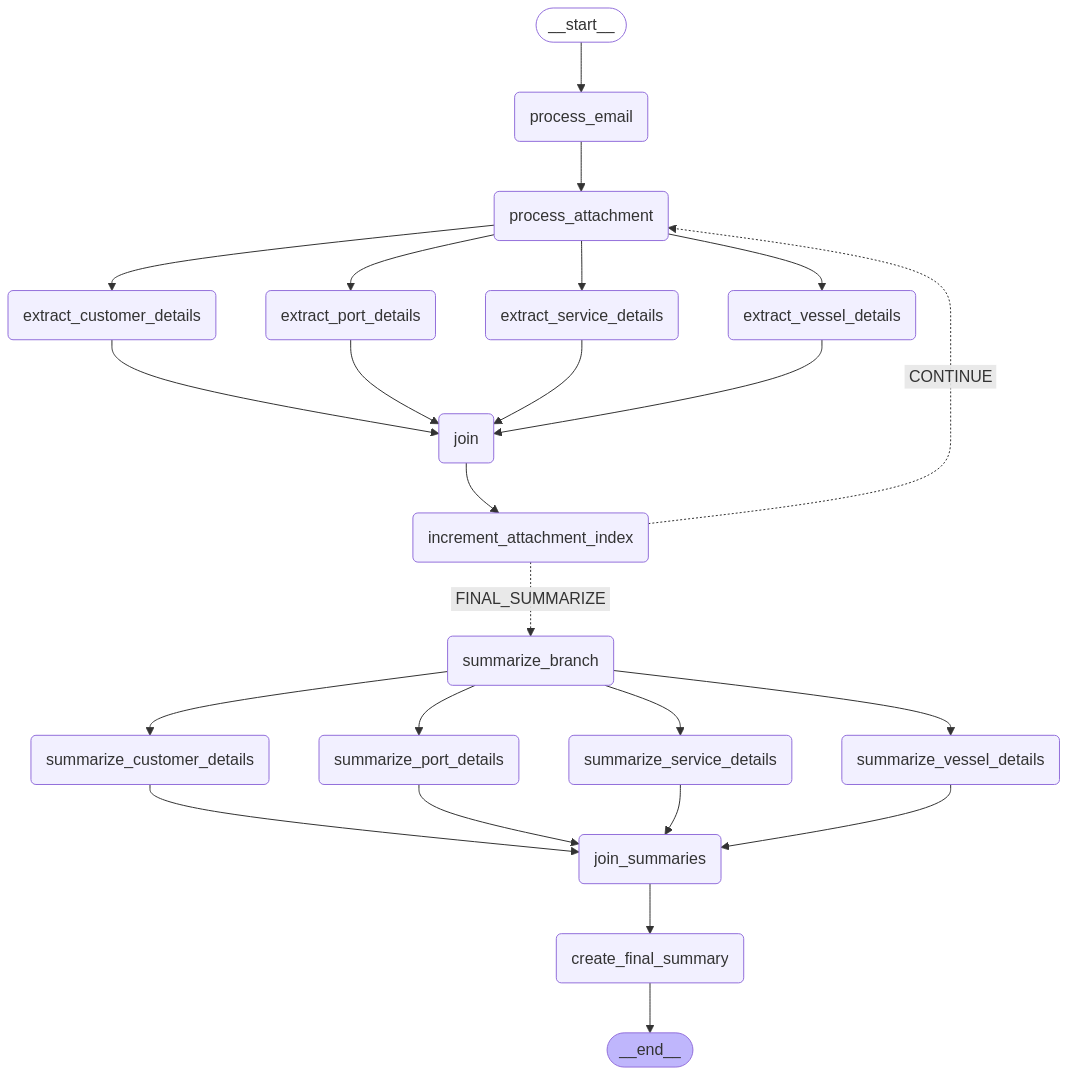

In [113]:
agent

In [21]:
# when to use invoke and when to use stream 
result = agent.invoke(initial_state)

msg <extract_msg.msg_classes.message.Message object at 0x73655e2fbfe0>
inside email process
{'email_file_path': 'buisness_emails/202501  CP-10011-2025-001  MINERVA PSARA  DISCHARGE VOYAGE INSTRUCTIONS.msg', 'email_content': 'Dear Captain Sakaleros,\r\n\r\n  \r\n\r\nPlease find attached 202501 Voyage Instructions V.5 and Terminal ETA Notices Template for your upcoming discharge at Montoir, France, on 23rd March 2025.\r\n\r\n \r\n\r\nImportant information:\r\n\r\n*\tFuel mode: gas only (using reliquefaction plant as required)\r\n*\tRAT: 23rd March 2025 / 00:01LT (to be adjusted for POB)\r\n*\tNotices to terminal can be sent as required.\r\n*\tPlease request Terminal Manual directly to agents.\r\n\r\n  \r\n\r\nPlease confirm safe receipt and understanding of this message.\r\n\r\n----\r\n\r\n \r\n\r\nDear GAC Agents RIC,\r\n\r\n \r\n\r\nPlease note the above and take this email as your formal nomination. All costs incurred relating to cargo operations will be under Venture Global Commoditi

In [22]:
from IPython.display import display, Markdown

display(Markdown(result['final_summary']))

Here is a structured summary of the email required to make a Proforma report for the customer:

**To:**
- **Company:** GAC Agents RIC
- **Org_no:** Not provided
- **Address:** Not provided
- **Country:** Not provided
- **Phone:** Not provided
- **Proforma_number:** 202501
- **Date:** 23rd March 2025
- **Job_ref:** CP-10011-2025-001
- **Contact_person:** Not provided

**From:**
- **Company:** Venture Global LNG
- **Address:** Not provided
- **Phone:** +44 20 4570 1617
- **Fax:** Not provided
- **Web:** Not provided

**Proforma:**
- **Vessel:** MINERVA PSARA
- **IMO:** Not provided
- **gt:** Not provided
- **nt:** Not provided
- **Voyage:** Discharge voyage at Montoir, France
- **ETA:** 23rd March 2025 / 00:01 LT
- **ETD:** Not provided
- **Port_country:** Montoir, France
- **Call_type:** Cargo
- **Items:**
  - **Description:** Fuel mode: gas only (using reliquefaction plant as required)
  - **Note:** Notices to terminal can be sent as required. Terminal Manual to be requested directly from agents.
  - **Proforma_gbp:** Not provided
  - **Final_gbp:** Not provided
  - **Variance:** Not provided
- **Total_gbp:** Not provided
- **Estimated_amount:** Not provided

**Additional Notes:**
- The email serves as formal nomination of GAC Agents RIC.
- All costs incurred relating to cargo operations will be charged to Venture Global Commodities, LLC (VGC) as charterers.
- The Captain is requested to confirm safe receipt and understanding of the message.

This summary provides all necessary details to create a Proforma report for the customer based on the provided email.

In [29]:
#user_input = f"what is the related shipping information to make quotation from file at file_path {file_path}"
for event in agent.stream(initial_state):
    event['messages'][-1].pretty_print()

msg <extract_msg.msg_classes.message.Message object at 0x734440b595e0>
inside email process
{'email_file_path': 'buisness_emails/202501  CP-10011-2025-001  MINERVA PSARA  DISCHARGE VOYAGE INSTRUCTIONS.msg', 'email_content': 'Dear Captain Sakaleros,\r\n\r\n  \r\n\r\nPlease find attached 202501 Voyage Instructions V.5 and Terminal ETA Notices Template for your upcoming discharge at Montoir, France, on 23rd March 2025.\r\n\r\n \r\n\r\nImportant information:\r\n\r\n*\tFuel mode: gas only (using reliquefaction plant as required)\r\n*\tRAT: 23rd March 2025 / 00:01LT (to be adjusted for POB)\r\n*\tNotices to terminal can be sent as required.\r\n*\tPlease request Terminal Manual directly to agents.\r\n\r\n  \r\n\r\nPlease confirm safe receipt and understanding of this message.\r\n\r\n----\r\n\r\n \r\n\r\nDear GAC Agents RIC,\r\n\r\n \r\n\r\nPlease note the above and take this email as your formal nomination. All costs incurred relating to cargo operations will be under Venture Global Commoditi

KeyError: 'messages'

In [ ]:
from IPython.display import display, Markdown

display(Markdown(event['messages'][-1].content))